In [ ]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.distributions import Normal, Categorical, Uniform
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
from tensorboardX import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

if torch.cuda.is_available():
    print(f"Название GPU: {torch.cuda.get_device_name()}")

Используемое устройство: cuda
Название GPU: Tesla T4


In [ ]:
class Config:
    def __init__(self):
        self.n_epoch = 100
        self.D_learning_rate = 2e-4
        self.G_learning_rate = 1e-3
        self.batch_size = 128
        self.leaky_rate = 0.1
        self.latent_dim = 62
        self.continuous_dim = 2
        self.categorical_dim = 10
        self.model_dir = "models/"
        self.res_dir = "results/"
        self.log_dir = "logs/"

config = Config()

os.makedirs(config.model_dir, exist_ok=True)
os.makedirs(config.res_dir, exist_ok=True)
os.makedirs(config.log_dir, exist_ok=True)

writer = SummaryWriter(config.log_dir)

In [ ]:
def sample(size, cat=-1, c1=None, c2=None, device='cuda'):
    # Случайный шум
    z = torch.FloatTensor(size, config.latent_dim).uniform_(-1, 1).to(device)

    # Непрерывные переменные
    if c1 is not None:
        z_con1 = torch.full((size, 1), c1, device=device, dtype=torch.float32)
    else:
        z_con1 = torch.FloatTensor(size, 1).uniform_(-1, 1).to(device)

    if c2 is not None:
        z_con2 = torch.full((size, 1), c2, device=device, dtype=torch.float32)
    else:
        z_con2 = torch.FloatTensor(size, 1).uniform_(-1, 1).to(device)

    # Категориальная переменная
    if cat >= 0:
        z_cat = F.one_hot(torch.full((size,), cat, device=device, dtype=torch.long),
                          config.categorical_dim).float()
    else:
        z_cat = F.one_hot(torch.randint(0, config.categorical_dim, (size,), device=device),
                          config.categorical_dim).float()

    # Объединяем все компоненты
    noise = torch.cat([z, z_con1, z_con2, z_cat], dim=1)
    return noise, z_con1, z_con2, z_cat

def q_sample(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

In [ ]:
# Функции потерь
def d_loss(real_output, fake_output):
    real_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output))
    fake_loss = F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

def g_loss(fake_output):
    return F.binary_cross_entropy_with_logits(fake_output, torch.ones_like(fake_output))

def info_loss(fkcon1, fkcon2, fkcat, z_con1, z_con2, z_cat):
    # Потери для непрерывных переменных (MSE)
    c1_loss = F.mse_loss(fkcon1, z_con1)
    c2_loss = F.mse_loss(fkcon2, z_con2)

    # Потери для категориальной переменной (cross entropy)
    cat_loss = F.cross_entropy(fkcat, torch.argmax(z_cat, dim=1))

    return c1_loss + c2_loss + cat_loss

In [ ]:
def train_display_img(generator, epoch, step):
    generator.eval()
    with torch.no_grad():
        # Генерируем изображения для разных категорий
        images = []
        for cat in range(4):
            noise, _, _, _ = sample(4, cat=cat, device=device)
            fake_images = generator(noise)
            images.append(fake_images)

        images = torch.cat(images, dim=0)
        images = (images + 1) / 2  # Денормализация

        # Сохраняем изображения
        grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Epoch {epoch}, Step {step}')
        plt.savefig(f"{config.res_dir}/img_{epoch:04d}_{step:04d}.png")
        plt.close()

        writer.add_image('Generated Images', grid, step)

    generator.train()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.input_dim = config.latent_dim + 1 + 1 + config.categorical_dim  # 62 + 1 + 1 + 10 = 74

        self.main = nn.Sequential(
            # FC: 74 -> 1024
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            # FC: 1024 -> 7*7*128
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(True),

            # Reshape: 6272 -> 128x7x7
            nn.Unflatten(1, (128, 7, 7)),

            # Deconv: 128x7x7 -> 64x14x14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Deconv: 64x14x14 -> 1x28x28
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            # Conv: 1x28x28 -> 64x14x14
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(config.leaky_rate, inplace=True),

            # Conv: 64x14x14 -> 128x7x7
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(config.leaky_rate, inplace=True),
        )

        self.fc_layers = nn.Sequential(
            # FC: 128*7*7 -> 1024
            nn.Flatten(),
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(config.leaky_rate, inplace=True),
        )

        self.discriminator_output = nn.Linear(1024, 1)

    def forward(self, x):
        features = self.conv_layers(x)
        mid_features = self.fc_layers(features)
        output = self.discriminator_output(mid_features)
        return output, mid_features

In [ ]:
# Вспомогательная сеть Q
class AuxiliaryNetwork(nn.Module):
    def __init__(self):
        super(AuxiliaryNetwork, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(config.leaky_rate, inplace=True),
        )

        # Выходы для предсказания латентных переменных
        self.categorical_output = nn.Linear(128, config.categorical_dim)
        self.continuous1_mu = nn.Linear(128, config.continuous_dim)
        self.continuous1_logvar = nn.Linear(128, config.continuous_dim)
        self.continuous2_mu = nn.Linear(128, config.continuous_dim)
        self.continuous2_logvar = nn.Linear(128, config.continuous_dim)

    def forward(self, x):
        features = self.main(x)

        cat = self.categorical_output(features)
        con1_mu = self.continuous1_mu(features)
        con1_logvar = self.continuous1_logvar(features)
        con2_mu = self.continuous2_mu(features)
        con2_logvar = self.continuous2_logvar(features)

        return cat, con1_mu, con1_logvar, con2_mu, con2_logvar

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator().to(device)
D = Discriminator().to(device)
Q = AuxiliaryNetwork().to(device)
G.apply(weights_init)
D.apply(weights_init)
Q.apply(weights_init)

if torch.cuda.device_count() > 1:
    print(f"Используется {torch.cuda.device_count()} GPU!")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)
    Q = nn.DataParallel(Q)

g_optimizer = optim.Adam(list(G.parameters()) + list(Q.parameters()),
                        lr=config.G_learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(),
                        lr=config.D_learning_rate, betas=(0.5, 0.999))

Модели инициализированы и перенесены на GPU


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация к [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                         num_workers=2, pin_memory=True)

print(f"Загружено {len(train_dataset)} тренировочных изображений")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 468kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]

Загружено 60000 тренировочных изображений


In [ ]:
def train_step(real_images):
    real_images = real_images.to(device)
    batch_size = real_images.size(0)

    # ===== ОБУЧЕНИЕ ДИСКРИМИНАТОРА =====
    d_optimizer.zero_grad()

    # Генерация шума
    noise, z_con1, z_con2, z_cat = sample(batch_size, device=device)

    # Генерация fake изображений
    with torch.no_grad():
        fake_images = G(noise)

    real_output, _ = D(real_images)
    fake_output, _ = D(fake_images)

    # Потери дискриминатора
    d_loss_value = d_loss(real_output, fake_output)
    d_loss_value.backward()
    d_optimizer.step()

    # ===== ОБУЧЕНИЕ ГЕНЕРАТОРА И ВСПОМОГАТЕЛЬНОЙ СЕТИ =====
    g_optimizer.zero_grad()

    # Генерация нового шума
    noise, z_con1, z_con2, z_cat = sample(batch_size, device=device)

    # Генерация fake изображений
    fake_images = G(noise)

    # Предсказания дискриминатора и вспомогательной сети
    fake_output, mid_features = D(fake_images)
    cat_pred, con1_mu, con1_logvar, con2_mu, con2_logvar = Q(mid_features)

    # Восстановление непрерывных переменных
    fkcon1 = q_sample(con1_mu, con1_logvar)
    fkcon2 = q_sample(con2_mu, con2_logvar)

    # Потери
    g_loss_value = g_loss(fake_output)
    info_loss_value = info_loss(fkcon1, fkcon2, cat_pred, z_con1, z_con2, z_cat)

    # Общие потери генератора
    total_g_loss = g_loss_value + info_loss_value
    total_g_loss.backward()
    g_optimizer.step()

    return g_loss_value.item(), d_loss_value.item(), info_loss_value.item()

In [ ]:
def train():
    G.train()
    D.train()
    Q.train()

    step = 0
    for epoch in range(config.n_epoch):
        g_losses = []
        d_losses = []
        info_losses = []

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.n_epoch}')

        for i, (real_images, _) in enumerate(progress_bar):
            g_loss, d_loss, info_loss = train_step(real_images)

            g_losses.append(g_loss)
            d_losses.append(d_loss)
            info_losses.append(info_loss)

            step += 1

            progress_bar.set_postfix({
                'G_Loss': f'{g_loss:.4f}',
                'D_Loss': f'{d_loss:.4f}',
                'Info_Loss': f'{info_loss:.4f}'
            })

            writer.add_scalar('Loss/Generator', g_loss, step)
            writer.add_scalar('Loss/Discriminator', d_loss, step)
            writer.add_scalar('Loss/Info', info_loss, step)

            if step % 100 == 0:
                train_display_img(G, epoch+1, step)

        avg_g_loss = np.mean(g_losses)
        avg_d_loss = np.mean(d_losses)
        avg_info_loss = np.mean(info_losses)

        print(f'[{time.strftime("%H:%M:%S")}] Epoch {epoch+1:03d} | '
              f'G: {avg_g_loss:.4f} | D: {avg_d_loss:.4f} | Info: {avg_info_loss:.4f}')

        torch.save(G.state_dict(), f'{config.model_dir}/generator_epoch_{epoch+1}.pth')
        torch.save(D.state_dict(), f'{config.model_dir}/discriminator_epoch_{epoch+1}.pth')
        torch.save(Q.state_dict(), f'{config.model_dir}/auxiliary_epoch_{epoch+1}.pth')

    writer.close()

In [ ]:
print("Начало обучения на PyTorch с GPU...")
train()

Начало обучения на PyTorch с GPU...


Epoch 1/100:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-956386970.py:12: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  c1_loss = F.mse_loss(fkcon1, z_con1)
/tmp/ipython-input-956386970.py:13: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  c2_loss = F.mse_loss(fkcon2, z_con2)
Epoch 1/100:  99%|█████████▉| 465/469 [00:22<00:00, 18.96it/s, G_Loss=1.1823, D_Loss=0.8707, Info_Loss=0.1543]/tmp/ipython-input-956386970.py:12: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same siz

[12:51:22] Epoch 001 | G: 1.2849 | D: 0.8550 | Info: 0.4305


Epoch 2/100: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s, G_Loss=1.2433, D_Loss=0.9934, Info_Loss=0.1031]


[12:51:40] Epoch 002 | G: 1.2150 | D: 0.9573 | Info: 0.1382


Epoch 3/100: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s, G_Loss=1.1331, D_Loss=1.1478, Info_Loss=0.1276]


[12:52:02] Epoch 003 | G: 1.1673 | D: 1.0157 | Info: 0.1107


Epoch 4/100: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s, G_Loss=1.1289, D_Loss=1.0872, Info_Loss=0.1025]


[12:52:22] Epoch 004 | G: 1.1321 | D: 1.0594 | Info: 0.0972


Epoch 5/100: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s, G_Loss=0.9776, D_Loss=1.1036, Info_Loss=0.0792]


[12:52:41] Epoch 005 | G: 1.1347 | D: 1.0544 | Info: 0.0931


Epoch 6/100: 100%|██████████| 469/469 [00:18<00:00, 24.75it/s, G_Loss=1.2227, D_Loss=1.0489, Info_Loss=0.1402]


[12:53:00] Epoch 006 | G: 1.1430 | D: 1.0418 | Info: 0.0867


Epoch 7/100: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s, G_Loss=1.2304, D_Loss=1.0352, Info_Loss=0.1050]


[12:53:19] Epoch 007 | G: 1.1870 | D: 1.0162 | Info: 0.0870


Epoch 8/100: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s, G_Loss=1.3085, D_Loss=1.0405, Info_Loss=0.0742]


[12:53:37] Epoch 008 | G: 1.2338 | D: 0.9782 | Info: 0.0868


Epoch 9/100: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s, G_Loss=1.4681, D_Loss=1.0408, Info_Loss=0.0620]


[12:53:56] Epoch 009 | G: 1.2834 | D: 0.9499 | Info: 0.0852


Epoch 10/100: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s, G_Loss=1.2301, D_Loss=0.9572, Info_Loss=0.1405]


[12:54:15] Epoch 010 | G: 1.3318 | D: 0.9195 | Info: 0.0845


Epoch 11/100: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s, G_Loss=0.8597, D_Loss=0.9699, Info_Loss=0.0801]


[12:54:33] Epoch 011 | G: 1.3867 | D: 0.8760 | Info: 0.0844


Epoch 12/100: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s, G_Loss=1.4594, D_Loss=0.7192, Info_Loss=0.0881]


[12:54:51] Epoch 012 | G: 1.4464 | D: 0.8470 | Info: 0.0866


Epoch 13/100: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s, G_Loss=1.5502, D_Loss=0.6836, Info_Loss=0.1428]


[12:55:09] Epoch 013 | G: 1.4794 | D: 0.8323 | Info: 0.0837


Epoch 14/100: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s, G_Loss=1.4087, D_Loss=0.7677, Info_Loss=0.0643]


[12:55:27] Epoch 014 | G: 1.5152 | D: 0.8199 | Info: 0.0851


Epoch 15/100: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s, G_Loss=1.5748, D_Loss=0.9295, Info_Loss=0.0816]


[12:55:44] Epoch 015 | G: 1.5729 | D: 0.7862 | Info: 0.0847


Epoch 16/100: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s, G_Loss=1.9413, D_Loss=0.8078, Info_Loss=0.1244]


[12:56:03] Epoch 016 | G: 1.6116 | D: 0.7631 | Info: 0.0841


Epoch 17/100: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s, G_Loss=2.3068, D_Loss=0.9672, Info_Loss=0.0777]


[12:56:20] Epoch 017 | G: 1.6633 | D: 0.7372 | Info: 0.0855


Epoch 18/100: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s, G_Loss=1.4080, D_Loss=0.6597, Info_Loss=0.0741]


[12:56:38] Epoch 018 | G: 1.7055 | D: 0.7279 | Info: 0.0854


Epoch 19/100: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s, G_Loss=1.7870, D_Loss=0.7553, Info_Loss=0.0706]


[12:56:57] Epoch 019 | G: 1.7622 | D: 0.6934 | Info: 0.0863


Epoch 20/100: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s, G_Loss=1.8925, D_Loss=0.5983, Info_Loss=0.0669]


[12:57:15] Epoch 020 | G: 1.7939 | D: 0.6991 | Info: 0.0874


Epoch 21/100: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s, G_Loss=2.5604, D_Loss=0.6265, Info_Loss=0.0707]


[12:57:33] Epoch 021 | G: 1.8258 | D: 0.6806 | Info: 0.0838


Epoch 22/100: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s, G_Loss=2.3201, D_Loss=0.7637, Info_Loss=0.0824]


[12:57:51] Epoch 022 | G: 1.8579 | D: 0.6547 | Info: 0.0876


Epoch 23/100: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s, G_Loss=1.5986, D_Loss=0.5396, Info_Loss=0.0791]


[12:58:09] Epoch 023 | G: 1.9153 | D: 0.6411 | Info: 0.0866


Epoch 24/100: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s, G_Loss=2.1227, D_Loss=0.6319, Info_Loss=0.0819]


[12:58:27] Epoch 024 | G: 1.9440 | D: 0.6459 | Info: 0.0893


Epoch 25/100: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s, G_Loss=2.5651, D_Loss=0.6212, Info_Loss=0.1216]


[12:58:45] Epoch 025 | G: 1.9686 | D: 0.6250 | Info: 0.0872


Epoch 26/100: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s, G_Loss=1.8595, D_Loss=0.6331, Info_Loss=0.0860]


[12:59:03] Epoch 026 | G: 1.9866 | D: 0.6113 | Info: 0.0852


Epoch 27/100: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s, G_Loss=1.6830, D_Loss=0.7513, Info_Loss=0.0943]


[12:59:21] Epoch 027 | G: 2.0449 | D: 0.5942 | Info: 0.0842


Epoch 28/100: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s, G_Loss=2.1799, D_Loss=0.4398, Info_Loss=0.0773]


[12:59:40] Epoch 028 | G: 2.0669 | D: 0.5958 | Info: 0.0880


Epoch 29/100: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s, G_Loss=1.6134, D_Loss=0.4472, Info_Loss=0.0780]


[12:59:57] Epoch 029 | G: 2.0903 | D: 0.5817 | Info: 0.0847


Epoch 30/100: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s, G_Loss=2.1695, D_Loss=0.6090, Info_Loss=0.0825]


[13:00:15] Epoch 030 | G: 2.1185 | D: 0.5860 | Info: 0.0866


Epoch 31/100: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s, G_Loss=2.5992, D_Loss=0.5019, Info_Loss=0.0688]


[13:00:33] Epoch 031 | G: 2.1658 | D: 0.5676 | Info: 0.0865


Epoch 32/100: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s, G_Loss=2.3108, D_Loss=0.5415, Info_Loss=0.0870]


[13:00:51] Epoch 032 | G: 2.1657 | D: 0.5669 | Info: 0.0906


Epoch 33/100: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s, G_Loss=1.6951, D_Loss=0.6436, Info_Loss=0.0889]


[13:01:10] Epoch 033 | G: 2.1982 | D: 0.5413 | Info: 0.0872


Epoch 34/100: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s, G_Loss=2.1337, D_Loss=0.5539, Info_Loss=0.0622]


[13:01:28] Epoch 034 | G: 2.2405 | D: 0.5422 | Info: 0.0862


Epoch 35/100: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s, G_Loss=2.2148, D_Loss=0.5108, Info_Loss=0.0943]


[13:01:47] Epoch 035 | G: 2.2665 | D: 0.5227 | Info: 0.0876


Epoch 36/100: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s, G_Loss=2.8750, D_Loss=0.6614, Info_Loss=0.0770]


[13:02:05] Epoch 036 | G: 2.3133 | D: 0.5169 | Info: 0.0863


Epoch 37/100: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s, G_Loss=2.6641, D_Loss=0.5293, Info_Loss=0.1000]


[13:02:22] Epoch 037 | G: 2.3322 | D: 0.5185 | Info: 0.0887


Epoch 38/100: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s, G_Loss=1.7341, D_Loss=0.6511, Info_Loss=0.0800]


[13:02:41] Epoch 038 | G: 2.3416 | D: 0.5152 | Info: 0.0881


Epoch 39/100: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s, G_Loss=2.2589, D_Loss=0.5052, Info_Loss=0.0901]


[13:02:58] Epoch 039 | G: 2.3928 | D: 0.5065 | Info: 0.0838


Epoch 40/100: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s, G_Loss=2.6093, D_Loss=0.5773, Info_Loss=0.0728]


[13:03:16] Epoch 040 | G: 2.4189 | D: 0.5103 | Info: 0.0874


Epoch 41/100: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s, G_Loss=3.0020, D_Loss=0.4567, Info_Loss=0.0841]


[13:03:34] Epoch 041 | G: 2.4178 | D: 0.4811 | Info: 0.0900


Epoch 42/100: 100%|██████████| 469/469 [00:17<00:00, 26.06it/s, G_Loss=2.5602, D_Loss=0.5494, Info_Loss=0.0562]


[13:03:52] Epoch 042 | G: 2.4803 | D: 0.4807 | Info: 0.0866


Epoch 43/100: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s, G_Loss=2.7503, D_Loss=0.4474, Info_Loss=0.2008]


[13:04:11] Epoch 043 | G: 2.5163 | D: 0.4692 | Info: 0.0865


Epoch 44/100: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s, G_Loss=2.7794, D_Loss=0.5592, Info_Loss=0.1062]


[13:04:28] Epoch 044 | G: 2.5428 | D: 0.4753 | Info: 0.0903


Epoch 45/100: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s, G_Loss=1.8847, D_Loss=0.6855, Info_Loss=0.0839]


[13:04:47] Epoch 045 | G: 2.5231 | D: 0.4648 | Info: 0.0849


Epoch 46/100: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s, G_Loss=3.4193, D_Loss=0.5476, Info_Loss=0.0694]


[13:05:04] Epoch 046 | G: 2.5797 | D: 0.4609 | Info: 0.0855


Epoch 47/100: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s, G_Loss=2.4242, D_Loss=0.5404, Info_Loss=0.0735]


[13:05:23] Epoch 047 | G: 2.6135 | D: 0.4601 | Info: 0.0904


Epoch 48/100: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s, G_Loss=2.4913, D_Loss=0.3432, Info_Loss=0.0772]


[13:05:41] Epoch 048 | G: 2.6448 | D: 0.4411 | Info: 0.0886


Epoch 49/100: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s, G_Loss=3.1723, D_Loss=0.4200, Info_Loss=0.0705]


[13:05:59] Epoch 049 | G: 2.6682 | D: 0.4460 | Info: 0.0918


Epoch 50/100: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s, G_Loss=3.2136, D_Loss=0.3876, Info_Loss=0.0701]


[13:06:18] Epoch 050 | G: 2.6779 | D: 0.4449 | Info: 0.0893


Epoch 51/100: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s, G_Loss=1.5563, D_Loss=0.4169, Info_Loss=0.0892]


[13:06:36] Epoch 051 | G: 2.7412 | D: 0.4280 | Info: 0.0884


Epoch 52/100: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s, G_Loss=2.6310, D_Loss=0.3946, Info_Loss=0.0885]


[13:06:55] Epoch 052 | G: 2.7659 | D: 0.4188 | Info: 0.0902


Epoch 53/100: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s, G_Loss=2.2431, D_Loss=0.3199, Info_Loss=0.0727]


[13:07:12] Epoch 053 | G: 2.7610 | D: 0.4214 | Info: 0.0894


Epoch 54/100: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s, G_Loss=2.2912, D_Loss=0.4578, Info_Loss=0.0786]


[13:07:31] Epoch 054 | G: 2.7852 | D: 0.4129 | Info: 0.0878


Epoch 55/100: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s, G_Loss=2.9198, D_Loss=0.4565, Info_Loss=0.1443]


[13:07:48] Epoch 055 | G: 2.8112 | D: 0.4280 | Info: 0.0876


Epoch 56/100: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s, G_Loss=2.6156, D_Loss=0.5899, Info_Loss=0.0937]


[13:08:06] Epoch 056 | G: 2.8373 | D: 0.4194 | Info: 0.0930


Epoch 57/100: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s, G_Loss=3.4207, D_Loss=0.3448, Info_Loss=0.0921]


[13:08:25] Epoch 057 | G: 2.8855 | D: 0.3964 | Info: 0.0903


Epoch 58/100: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s, G_Loss=1.6354, D_Loss=0.5868, Info_Loss=0.1715]


[13:08:43] Epoch 058 | G: 2.8981 | D: 0.4085 | Info: 0.0903


Epoch 59/100: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s, G_Loss=2.5465, D_Loss=0.4546, Info_Loss=0.0739]


[13:09:02] Epoch 059 | G: 2.9012 | D: 0.3962 | Info: 0.0904


Epoch 60/100: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s, G_Loss=2.7226, D_Loss=0.3695, Info_Loss=0.1102]


[13:09:20] Epoch 060 | G: 2.9120 | D: 0.4048 | Info: 0.0882


Epoch 61/100: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s, G_Loss=1.9289, D_Loss=0.5741, Info_Loss=0.1933]


[13:09:39] Epoch 061 | G: 2.9733 | D: 0.3855 | Info: 0.0904


Epoch 62/100: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s, G_Loss=2.7474, D_Loss=0.3313, Info_Loss=0.0647]


[13:09:57] Epoch 062 | G: 3.0222 | D: 0.3784 | Info: 0.0905


Epoch 63/100: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s, G_Loss=3.7579, D_Loss=0.2988, Info_Loss=0.0875]


[13:10:16] Epoch 063 | G: 3.0336 | D: 0.3809 | Info: 0.0901


Epoch 64/100: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s, G_Loss=3.1919, D_Loss=0.2439, Info_Loss=0.1198]


[13:10:34] Epoch 064 | G: 3.0751 | D: 0.3624 | Info: 0.0909


Epoch 65/100: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s, G_Loss=2.9015, D_Loss=0.2997, Info_Loss=0.0678]


[13:10:52] Epoch 065 | G: 3.0432 | D: 0.3866 | Info: 0.0901


Epoch 66/100: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s, G_Loss=2.8260, D_Loss=0.2873, Info_Loss=0.0763]


[13:11:11] Epoch 066 | G: 3.1303 | D: 0.3587 | Info: 0.0902


Epoch 67/100: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s, G_Loss=3.2140, D_Loss=0.3479, Info_Loss=0.0908]


[13:11:29] Epoch 067 | G: 3.1414 | D: 0.3478 | Info: 0.0896


Epoch 68/100: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s, G_Loss=3.7343, D_Loss=0.4318, Info_Loss=0.1169]


[13:11:48] Epoch 068 | G: 3.1574 | D: 0.3593 | Info: 0.0918


Epoch 69/100: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s, G_Loss=2.5397, D_Loss=0.4524, Info_Loss=0.0978]


[13:12:06] Epoch 069 | G: 3.1502 | D: 0.3478 | Info: 0.0940


Epoch 70/100: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s, G_Loss=2.9346, D_Loss=0.3587, Info_Loss=0.1012]


[13:12:24] Epoch 070 | G: 3.1949 | D: 0.3571 | Info: 0.0912


Epoch 71/100: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s, G_Loss=3.8069, D_Loss=0.3015, Info_Loss=0.0927]


[13:12:43] Epoch 071 | G: 3.2157 | D: 0.3476 | Info: 0.0897


Epoch 72/100: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s, G_Loss=3.2991, D_Loss=0.2848, Info_Loss=0.0957]


[13:13:01] Epoch 072 | G: 3.2773 | D: 0.3298 | Info: 0.0884


Epoch 73/100: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s, G_Loss=3.3915, D_Loss=0.3764, Info_Loss=0.0828]


[13:13:20] Epoch 073 | G: 3.3032 | D: 0.3425 | Info: 0.0929


Epoch 74/100: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s, G_Loss=3.5964, D_Loss=0.2890, Info_Loss=0.0631]


[13:13:38] Epoch 074 | G: 3.2857 | D: 0.3476 | Info: 0.0901


Epoch 75/100: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s, G_Loss=2.7824, D_Loss=0.4865, Info_Loss=0.1320]


[13:13:56] Epoch 075 | G: 3.3431 | D: 0.3332 | Info: 0.0927


Epoch 76/100: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s, G_Loss=4.7995, D_Loss=0.3856, Info_Loss=0.1093]


[13:14:14] Epoch 076 | G: 3.3606 | D: 0.3320 | Info: 0.0941


Epoch 77/100: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s, G_Loss=3.0010, D_Loss=0.3148, Info_Loss=0.1050]


[13:14:32] Epoch 077 | G: 3.3769 | D: 0.3367 | Info: 0.0929


Epoch 78/100: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s, G_Loss=3.6034, D_Loss=0.5206, Info_Loss=0.1019]


[13:14:50] Epoch 078 | G: 3.4179 | D: 0.3277 | Info: 0.0915


Epoch 79/100: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s, G_Loss=3.3735, D_Loss=0.4740, Info_Loss=0.1412]


[13:15:08] Epoch 079 | G: 3.4218 | D: 0.3159 | Info: 0.0932


Epoch 80/100: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s, G_Loss=2.8536, D_Loss=0.4118, Info_Loss=0.0797]


[13:15:27] Epoch 080 | G: 3.4319 | D: 0.3186 | Info: 0.0904


Epoch 81/100: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s, G_Loss=4.1460, D_Loss=0.5824, Info_Loss=0.1403]


[13:15:45] Epoch 081 | G: 3.4763 | D: 0.3119 | Info: 0.0883


Epoch 82/100: 100%|██████████| 469/469 [00:19<00:00, 24.34it/s, G_Loss=4.6274, D_Loss=0.4464, Info_Loss=0.0898]


[13:16:05] Epoch 082 | G: 3.4877 | D: 0.3229 | Info: 0.0908


Epoch 83/100: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s, G_Loss=2.4283, D_Loss=0.2839, Info_Loss=0.1486]


[13:16:22] Epoch 083 | G: 3.5313 | D: 0.3063 | Info: 0.0906


Epoch 84/100: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s, G_Loss=3.2947, D_Loss=0.5393, Info_Loss=0.1005]


[13:16:40] Epoch 084 | G: 3.5873 | D: 0.2869 | Info: 0.0884


Epoch 85/100: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s, G_Loss=3.7819, D_Loss=0.3633, Info_Loss=0.0908]


[13:16:59] Epoch 085 | G: 3.5554 | D: 0.3186 | Info: 0.0929


Epoch 86/100: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s, G_Loss=3.3944, D_Loss=0.3521, Info_Loss=0.1445]


[13:17:17] Epoch 086 | G: 3.5978 | D: 0.2962 | Info: 0.0914


Epoch 87/100: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s, G_Loss=3.3090, D_Loss=0.3148, Info_Loss=0.1151]


[13:17:35] Epoch 087 | G: 3.5835 | D: 0.3085 | Info: 0.0921


Epoch 88/100: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s, G_Loss=4.8928, D_Loss=0.2708, Info_Loss=0.0844]


[13:17:53] Epoch 088 | G: 3.6124 | D: 0.3014 | Info: 0.0910


Epoch 89/100: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s, G_Loss=3.2563, D_Loss=0.3149, Info_Loss=0.1386]


[13:18:13] Epoch 089 | G: 3.6749 | D: 0.2895 | Info: 0.0924


Epoch 90/100: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s, G_Loss=3.4575, D_Loss=0.2991, Info_Loss=0.0739]


[13:18:30] Epoch 090 | G: 3.7006 | D: 0.2828 | Info: 0.0919


Epoch 91/100: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s, G_Loss=2.9191, D_Loss=0.3388, Info_Loss=0.1017]


[13:18:48] Epoch 091 | G: 3.7182 | D: 0.2944 | Info: 0.0912


Epoch 92/100: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s, G_Loss=2.7819, D_Loss=0.4359, Info_Loss=0.0816]


[13:19:07] Epoch 092 | G: 3.7119 | D: 0.2851 | Info: 0.0906


Epoch 93/100: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s, G_Loss=4.7496, D_Loss=0.4977, Info_Loss=0.1241]


[13:19:24] Epoch 093 | G: 3.7437 | D: 0.2690 | Info: 0.0894


Epoch 94/100: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s, G_Loss=3.7849, D_Loss=0.3175, Info_Loss=0.0667]


[13:19:43] Epoch 094 | G: 3.8032 | D: 0.2742 | Info: 0.0918


Epoch 95/100: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s, G_Loss=3.7895, D_Loss=0.3615, Info_Loss=0.0686]


[13:20:01] Epoch 095 | G: 3.8440 | D: 0.2783 | Info: 0.0920


Epoch 96/100: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s, G_Loss=4.0866, D_Loss=0.3446, Info_Loss=0.0629]


[13:20:19] Epoch 096 | G: 3.8200 | D: 0.2759 | Info: 0.0911


Epoch 97/100: 100%|██████████| 469/469 [00:17<00:00, 26.06it/s, G_Loss=4.0779, D_Loss=0.2473, Info_Loss=0.0960]


[13:20:37] Epoch 097 | G: 3.8593 | D: 0.2792 | Info: 0.0910


Epoch 98/100: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s, G_Loss=3.6725, D_Loss=0.4455, Info_Loss=0.1168]


[13:20:55] Epoch 098 | G: 3.8779 | D: 0.2586 | Info: 0.0913


Epoch 99/100: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s, G_Loss=3.9946, D_Loss=0.2243, Info_Loss=0.0695]


[13:21:14] Epoch 099 | G: 3.8921 | D: 0.2724 | Info: 0.0900


Epoch 100/100: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s, G_Loss=3.9390, D_Loss=0.2765, Info_Loss=0.0871]


[13:21:32] Epoch 100 | G: 3.9680 | D: 0.2511 | Info: 0.0888


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r /content/models.zip /content/models/*epoch_100.pth /content/models/*epoch_90.pth /content/models/*epoch_50.pth

updating: content/models/generator_epoch_90.pth (deflated 7%)
updating: content/models/auxiliary_epoch_50.pth (deflated 8%)
updating: content/models/discriminator_epoch_100.pth (deflated 7%)
updating: content/models/discriminator_epoch_90.pth (deflated 7%)
updating: content/models/auxiliary_epoch_100.pth (deflated 8%)
updating: content/models/generator_epoch_100.pth (deflated 7%)
updating: content/models/auxiliary_epoch_90.pth (deflated 8%)
updating: content/models/discriminator_epoch_50.pth (deflated 7%)
updating: content/models/generator_epoch_50.pth (deflated 7%)


In [ ]:
!cp /content/models.zip "/content/drive/My Drive/models"

In [ ]:
!cp /content/models "/content/drive/My Drive/" -r

In [ ]:
!cp /content/results "/content/drive/My Drive/results" -r

In [ ]:
!cp /content/test_torch "/content/drive/My Drive/test_torch" -r

In [ ]:
def test_sample_torch(z, size, cat=-1, c1=None, c2=None, device='cuda'):
    if c1 is not None:
        z_con1 = torch.full((size, 1), c1, device=device, dtype=torch.float32)
    else:
        z_con1 = torch.FloatTensor(size, 1).uniform_(-1, 1).to(device)

    if c2 is not None:
        z_con2 = torch.full((size, 1), c2, device=device, dtype=torch.float32)
    else:
        z_con2 = torch.FloatTensor(size, 1).uniform_(-1, 1).to(device)

    if cat >= 0:
        z_cat = F.one_hot(torch.full((size,), cat, device=device, dtype=torch.long),
                          config.categorical_dim).float()
    else:
        z_cat = F.one_hot(torch.randint(0, config.categorical_dim, (size,), device=device),
                          config.categorical_dim).float()

    noise = torch.cat([z, z_con1, z_con2, z_cat], dim=1)
    return noise

os.makedirs("./test_torch", exist_ok=True)

In [ ]:
def load_model_for_testing(epoch_number):
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(f'{config.model_dir}/generator_epoch_{epoch_number}.pth'))
    generator.eval()
    return generator

# Тестирование
epoch_to_test = int(input('Введите номер эпохи для тестирования: '))
G_test = load_model_for_testing(epoch_to_test)
print("Модель загружена для тестирования")

Введите номер эпохи для тестирования: 100
Модель загружена для тестирования


Генерация тестовых изображений...


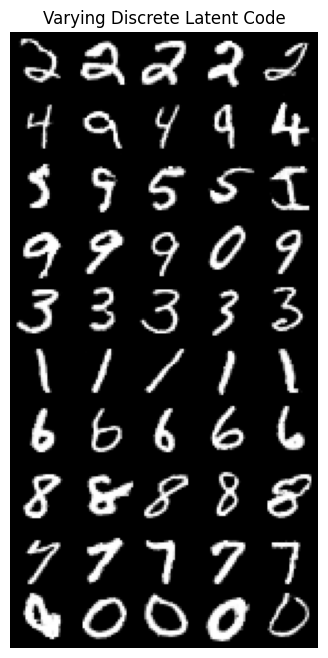

Тестирование завершено!


In [ ]:
print("Генерация тестовых изображений...")

with torch.no_grad():
    # 1. Генерация по категориям
    output_images = []
    for digit in range(10):
        z = torch.FloatTensor(5, config.latent_dim).uniform_(-1, 1).to(device)
        noise = test_sample_torch(z, 5, cat=digit, device=device)
        imgs = G_test(noise)
        imgs = (imgs + 1) / 2

        # Подготовка для отображения
        imgs_cpu = imgs.cpu()
        row_imgs = torch.cat([imgs_cpu[i] for i in range(5)], dim=2)
        output_images.append(row_imgs)

    final_image = torch.cat(output_images, dim=1).squeeze()

    plt.figure(figsize=(15, 8))
    plt.imshow(final_image.numpy(), cmap='gray')
    plt.title('Varying Discrete Latent Code')
    plt.axis('off')
    plt.savefig('./test_torch/categorical_generation.png', bbox_inches='tight', pad_inches=0)
    plt.show()

print("Тестирование завершено!")